In [1]:
import os

import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pylab as plt


import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, random_split 

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True

False


# Parameter Settings



We define here the hyperparameters of the neural network to be built. We generate scenarios over N_days. The input paramaters are the hour per hour values of the forecast extending over this period, as well as the start hour of the forecast. In order to achieve satisfactory performances, the output is of the following format: according to a parameter h_approx, it is composed of a vector representing the average error over successive disjjoint periods of h_approx hours and a vector representing the forecast error variation around that average error for each period.

The parameters in_features_dims and out_features_dims reflects the dimensions of these inputs and outputs. The parameter latent_dims corresponds to the latent space dimension from which possible realizations are sampled.

The "beta" parameters represent the ponderation of the KL-divergence in the overall loss depending of the epoch. This method called Beta-annealing is used here to limit the so-called ["posterior collapse"](https://proceedings.neurips.cc/paper/2021/file/2b6921f2c64dee16ba21ebf17f3c2c92-Paper.pdf), allowing for a training with an alternating focus on the KL-divergence loss and the reconstruction loss. See, e.g., [this article](https://arxiv.org/pdf/1903.10145.pdf) for more information on the topic.



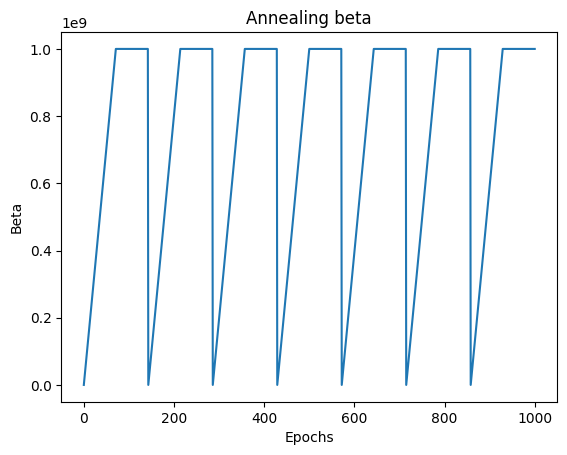

In [36]:
N_days=1
h_approx = 4
len_approx = int(N_days*24*1./h_approx)
in_features_dims = 1+N_days*24
out_features_dims =N_days*24  + int(N_days*24*1./h_approx)
latent_dims = in_features_dims

num_epochs = 1000
batch_size = 64*32
learning_rate = 5e-5
use_gpu = True

N_period = 7
beta_scale = 1e9
annealing_period = int(num_epochs*1./N_period)+1
beta_period = np.concatenate((np.arange(int(annealing_period*1./2))*1./int(annealing_period*1./2), np.ones(annealing_period-int(annealing_period*1./2)) ) )
beta_tab = beta_scale*np.concatenate([beta_period for p in range(N_period)])

plt.plot(np.arange(len(beta_tab)), beta_tab)
plt.title('Annealing beta')
plt.xlabel('Epochs')
plt.ylabel('Beta')
plt.show()

# Wind Power Data Loading

Training and testing datasets are defined below. The testing dataset corresponds to the data used in the simulation of the production plant. The input and output data is normalized, with a difference in normalization between the two output vector defined above. 

In [3]:
def extend(v, h_approx):
    
    v = np.array([v[int(h*1./h_approx)] for h in range(v.shape[0]*h_approx)])
    return v

#Accessing training and testing data
file_prev='../data/Historical_Forecasted_Wind_Power.csv'
data = pd.read_csv(file_prev,sep=';',decimal='.').dropna()
N=len(data.keys())
Peol_prev_train = np.array([ np.array(data['n_'+str(h)],dtype="float")[:N_days*24] for h in range(N)])

file_reel='../data/Historical_Actual_Wind_Power.csv'
data = pd.read_csv(file_reel,sep=';',decimal='.').dropna()
N=len(data.keys())
Peol_reel_train = np.array([ np.array(data['n_'+str(h)],dtype="float")[:N_days*24] for h in range(N)])

file_prev='../data/Test_Forecasted_Wind_Power.csv'
data = pd.read_csv(file_prev,sep=';',decimal='.').dropna()
N=len(data.keys())
Peol_prev_test = np.array([ np.array(data['n_'+str(h)],dtype="float")[:N_days*24] for h in range(N)])

file_reel='../data/Test_Actual_Wind_Power.csv'
data = pd.read_csv(file_reel,sep=';',decimal='.').dropna()
N=len(data.keys())
Peol_reel_test = np.array([ np.array(data['n_'+str(h)],dtype="float")[:N_days*24] for h in range(N)])

#Avoid zero division
Peol_prev_train = Peol_prev_train + 1
Peol_reel_train=Peol_reel_train +1
Peol_prev_test=Peol_prev_test +1
Peol_reel_test=Peol_reel_test +1

# Ouptut computed as the forecast error compared to the actual wind power value
output_train = np.array(Peol_reel_train - Peol_prev_train)
output_test = np.array(Peol_reel_test - Peol_prev_test)


#Output formatted as a vector of average error values and a second vector of variations around these average error values
output_test_approx = np.reshape(output_test, (output_test.shape[0],-1,h_approx))
output_test_approx = np.mean( output_test_approx, axis=2) 
output_train_approx = np.reshape(output_train, (output_train.shape[0],-1,h_approx))
output_train_approx = np.mean( output_train_approx, axis=2) 

output_test_var = np.array([  output_test[i]-extend(output_test_approx[i],h_approx) for i in range(output_test.shape[0]) ])
output_train_var = np.array([  output_train[i]-extend(output_train_approx[i],h_approx) for i in range(output_train.shape[0]) ])


#Normalization of the input and the output, for both vector separately

max_val = max(np.max(Peol_prev_train), np.max(Peol_prev_test))
max_val_train = np.max(Peol_prev_train,axis=1)
max_val_test = np.max(Peol_prev_test,axis=1)

max_val_approx = max(np.max(output_train_approx), np.max(output_test_approx))
max_val_train_approx = np.max(output_train_approx,axis=1)
max_val_test_approx = np.max(output_test_approx,axis=1)

max_val_var = max(np.max(np.abs(output_train_var)), np.max(np.abs(output_test_var)))
max_val_train_var = np.max(output_train_var,axis=1)
max_val_test_var = np.max(output_test_var,axis=1)

output_train = np.array([ np.concatenate((output_train_approx[i]*1./max_val_approx, output_train_var[i]*1./max_val_var)) for i in range(output_train.shape[0]) ])
output_test = np.array([ np.concatenate((output_test_approx[i]*1./max_val_approx, output_test_var[i]*1./max_val_var)) for i in range(output_test.shape[0]) ])

input_train = np.array([ Peol_prev_train[i]*1./max_val for i in range(Peol_prev_train.shape[0])])
input_test = np.array([ Peol_prev_test[i]*1./max_val for i in range(Peol_prev_test.shape[0])])

#Hour of start integrated to the input 
input_train = np.array([ np.concatenate((np.ones(1)*(start%24)*1./24,input_train[start])) for start in range(input_train.shape[0])])
input_test = np.array([ np.concatenate((np.ones(1)*(start%24)*1./24,input_test[start])) for start in range(input_test.shape[0])])


#Dataset definition

print("Number of samples :",output_train.shape[0])

my_dataset_train = TensorDataset(torch.Tensor( input_train),torch.Tensor( output_train)) 
my_dataset_test = TensorDataset(torch.Tensor( input_test ),torch.Tensor( output_test )) 

train_dataloader = DataLoader(my_dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    
test_dataloader = DataLoader(my_dataset_test, batch_size=batch_size, shuffle=True, pin_memory=True)
for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    


Number of samples : 10777


Variational Autoencoders (VAEs)
======


The Variational Auto-Encoder implemented here corresponds to a configuration commonly found in the litterature: a gaussian multivariate distribution for the conditional distribution of latent vectors given a forecast in input ($q_{\phi}(z | x_i)$) and a MSE loss for the reconstruction. Here, a fully connected multi-layer perceptron is implemented with a ReLu activation function. See [this article](https://arxiv.org/pdf/1312.6114.pdf) for more details on VAE. 

We first define the Encoder and Decoder parts of the VAE.

In [37]:
class EncoderVariationel(nn.Module):
    def __init__(self):
        super(EncoderVariationel, self).__init__()
        self.fc1 = nn.Linear(in_features=in_features_dims, out_features=in_features_dims)
        self.fc2 = nn.Linear(in_features=in_features_dims, out_features=in_features_dims)
        self.fc3 = nn.Linear(in_features=in_features_dims, out_features=in_features_dims)
        self.fc_mu = nn.Linear(in_features=in_features_dims, out_features=latent_dims)
        self.fc_mu_2 = nn.Linear(in_features=latent_dims, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=in_features_dims, out_features=latent_dims)
        self.fc_logvar_2 = nn.Linear(in_features=latent_dims, out_features=latent_dims)
            
    def forward(self, x):   
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        
        x_mu = F.relu(self.fc_mu(x))
        x_mu = self.fc_mu_2(x_mu)

        
        x_logvar = F.relu(self.fc_logvar(x))
        x_logvar = self.fc_logvar_2(x_logvar)

        return x_mu, x_logvar
    
class DecoderVariationel(nn.Module):
    def __init__(self):
        super(DecoderVariationel, self).__init__()
        self.fc3 = nn.Linear(in_features=latent_dims, out_features=latent_dims)
        self.fc2 = nn.Linear(in_features=latent_dims, out_features=out_features_dims)
        self.fc1 = nn.Linear(in_features=out_features_dims, out_features=out_features_dims)
            
    def forward(self, x):   
        x = self.fc3(x)
        x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

The VAE is simply defined as the concatenation of the Encoder and Decoder defined above. Note the use of the reparameterization trick for random sampling.

In [38]:

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = EncoderVariationel()
        self.decoder = DecoderVariationel()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)


## Loss function and training

The loss function is defined by the sum of a KL-divergence and a MSE loss, with the former being ponderated by a parameter beta as per the annealing method implemented and described above.

In [39]:
def vae_loss(recon_x, x, mu, logvar, beta):

    loss = nn.MSELoss()
    
    recon_loss = loss(recon_x, x)
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta*kldivergence, beta*kldivergence, recon_loss



We define the training loop 

In [40]:
def train_batch_vae(net, X, y, loss, trainer, devices, beta):
    """Train for a minibatch with multiple GPUs capabilities"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])

    net.train()

    trainer.zero_grad()

    recon_x, latent_mu, latent_logvar = net(X)

    l, KL_loss, recon_loss = loss(recon_x, y, latent_mu, latent_logvar, beta)

    # on fait la rétro-propagation du gradient
    l.sum().backward()
    
    torch.nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=1., norm_type=2.0)
    

    trainer.step()

    train_loss_sum = l.sum()
    train_KL_loss_sum = KL_loss.sum()
    train_recon_loss_sum = recon_loss.sum()
    return train_loss_sum, train_KL_loss_sum, train_recon_loss_sum

def test_batch_vae(net, X, y, loss, trainer, devices, beta):
    """Train for a minibatch with multiple GPUs capabilities"""

    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])

    net.eval()

    recon_x, latent_mu, latent_logvar = net(X)

    l, KL_loss, recon_loss = loss(recon_x, y, latent_mu, latent_logvar, beta)

    train_loss_sum = l.sum()
    train_KL_loss_sum = KL_loss.sum()
    train_recon_loss_sum = recon_loss.sum()
    return train_loss_sum, train_KL_loss_sum, train_recon_loss_sum

In [41]:
def train_vae(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=[device]):

    
    num_batches = len(train_iter)
    
    # declare network for multiple GPU :
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    tab_loss = []
    tab_KL_loss = []
    tab_recon_loss = []
    
    test_tab_loss = []
    test_tab_KL_loss = []
    test_tab_recon_loss = []

    for epoch in range(num_epochs):

        
        loss_e = 0
        loss_KL = 0
        loss_recon = 0
        
        test_loss_e = 0
        test_loss_KL = 0
        test_loss_recon = 0

        beta = beta_tab[epoch]
        
        for i, (features, labels) in enumerate(train_iter):
       

            l, KL_l, recon_l = train_batch_vae(net, features, labels, loss, trainer, devices, beta)
            
            loss_e += l.cpu().detach().numpy()
            loss_KL += KL_l.cpu().detach().numpy()
            loss_recon += recon_l.cpu().detach().numpy()
            
        for i, (X, y) in enumerate(test_iter):
       
            l, KL_l, recon_l = train_batch_vae(net, features, labels, loss, trainer, devices, beta)
            
            test_loss_e += l.cpu().detach().numpy()
            test_loss_KL += KL_l.cpu().detach().numpy()
            test_loss_recon += recon_l.cpu().detach().numpy()

        tab_loss.append(loss_e)
        tab_KL_loss.append(loss_KL)
        tab_recon_loss.append(loss_recon)
        
        test_tab_loss.append(test_loss_e)
        test_tab_KL_loss.append(test_loss_KL)
        test_tab_recon_loss.append(test_loss_recon)
        
    plt.plot(np.arange(len(tab_recon_loss)), np.log(np.array(tab_recon_loss))/np.log(10))
    plt.plot(np.arange(len(tab_recon_loss)), np.log(np.array(test_tab_recon_loss))/np.log(10))
    plt.ylabel("Loss")
    plt.xlabel('Epoch')
    plt.title('Recon log loss')
    plt.legend(['train','test'])
    plt.show()
        
    plt.plot(np.arange(len(tab_KL_loss)), np.log(np.array(tab_KL_loss))/np.log(10))
    plt.plot(np.arange(len(tab_KL_loss)), np.log(np.array(test_tab_KL_loss))/np.log(10))
    plt.ylabel("Loss")
    plt.xlabel('Epoch')
    plt.title('KL log loss')
    plt.legend(['train','test'])
    plt.show()
        
    plt.plot(np.arange(len(tab_loss)), np.log(np.array(tab_loss))/np.log(10))
    plt.plot(np.arange(len(tab_loss)), np.log(np.array(test_tab_loss))/np.log(10))
    plt.ylabel("Loss")
    plt.xlabel('Epoch')
    plt.title('Log loss')
    plt.legend(['train','test'])
    plt.show()

VAE training 
--------

Overfitting for Variational Auto-Encoder causes "posterior vanishing", in other words a convergence toward identity. To avoid such phenomenon, the training must be stopped before full convergence of the gradient descent. 

In [42]:
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 6910


In [43]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-7)

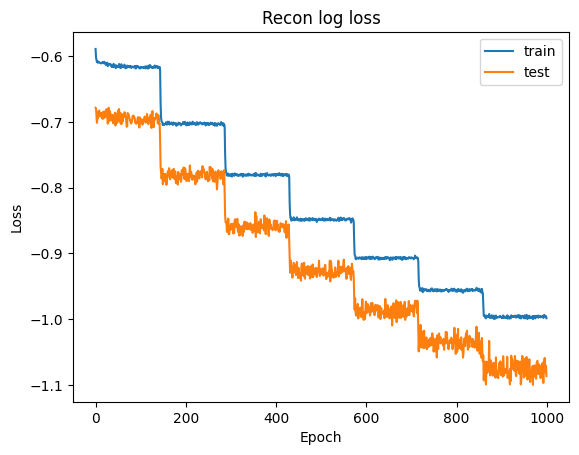

C:\Users\VictorSpitzer\AppData\Local\Temp\ipykernel_15800\4167984372.py:64: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(len(tab_KL_loss)), np.log(np.array(tab_KL_loss))/np.log(10))
C:\Users\VictorSpitzer\AppData\Local\Temp\ipykernel_15800\4167984372.py:65: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(len(tab_KL_loss)), np.log(np.array(test_tab_KL_loss))/np.log(10))


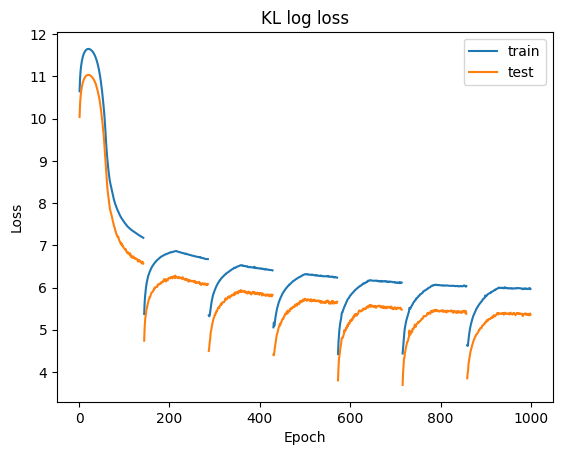

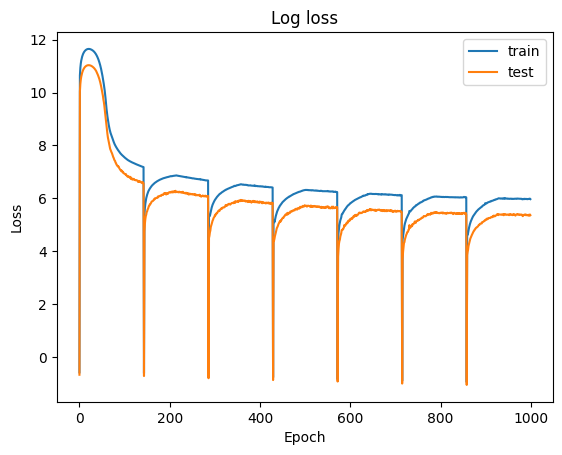

In [44]:
train_vae(vae, train_dataloader, test_dataloader , vae_loss, optimizer, num_epochs)

## Results
We display an example of scenario generation from the test data

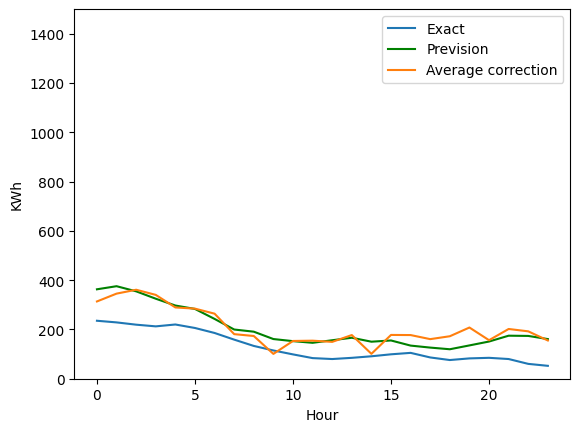

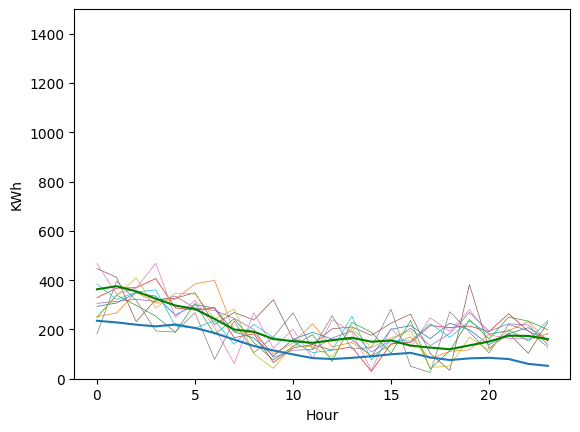

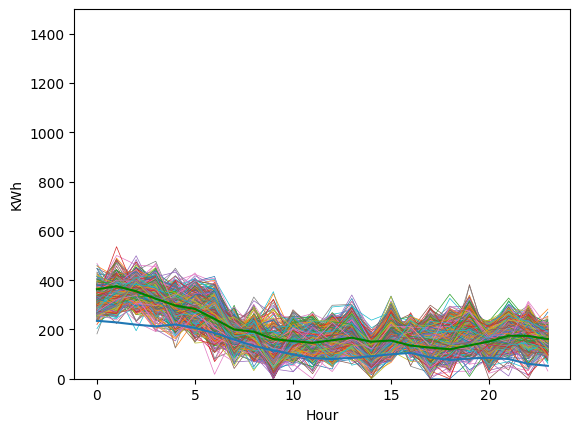

In [59]:
def extend(v, h_approx):
    
    v = np.array([v[int(h*1./h_approx)] for h in range(v.shape[0]*h_approx)])
    return v


vae.eval()

for Xt, yt in test_dataloader:

    if isinstance(Xt, list):
        X_tst = [x.to(device) for x in Xt]
    else:
        X_tst = Xt.to(device)
        
    y_tst = yt.to(device)
    
    break

np.set_printoptions(threshold=sys.maxsize)
    
a = 2

array_in = Xt.cpu().detach().numpy()[a,1:]
array_prev = array_in*max_val

array_exact = extend(yt.cpu().detach().numpy()[a,:len_approx],h_approx)*max_val_approx + yt.cpu().detach().numpy()[a,len_approx:]*max_val_var + array_prev

tab_res = []

for i in range(1000):
    

    res, latent_mu, latent_var = vae.forward(X_tst)

    res = extend(res.cpu().detach().numpy()[a,:len_approx],h_approx)*max_val_approx + res.cpu().detach().numpy()[a,len_approx:]*max_val_var + array_prev
    #res = extend(res.cpu().detach().numpy()[a]*array_in[0]*max_val+approx_prev, h_approx)

    res = np.maximum(res,0)
    
    
    tab_res.append(res)


plt.plot(np.arange(len(array_exact)), array_exact)
plt.plot(np.arange(len(array_prev)), array_prev, color='green')
plt.plot(np.arange(len(tab_res[0])), np.mean(np.array(tab_res),axis=0))
plt.legend(['Exact','Prevision','Average correction'])
plt.xlabel('Hour')
plt.ylabel("KWh")
plt.ylim([0,1500])
plt.show()


for i in range(10):
    plt.plot(np.arange(len(tab_res[0])), tab_res[i], linewidth=0.5)
plt.plot(np.arange(len(array_exact)), array_exact)
plt.plot(np.arange(len(array_prev)), array_prev, color='green')
plt.xlabel('Hour')
plt.ylabel("KWh")
plt.ylim([0,1500])
plt.show()

for i in range(1000):
    plt.plot(np.arange(len(tab_res[0])), tab_res[i], linewidth=0.5)
plt.plot(np.arange(len(array_exact)), array_exact)
plt.plot(np.arange(len(array_prev)), array_prev, color='green')
plt.xlabel('Hour')
plt.ylabel("KWh")
plt.ylim([0,1500])
plt.show()




Save neural network for reproducibility purposes

In [60]:
torch.save(vae.state_dict(), "Scenario_generation_VAE")